# Exploratory Data Analysis

In [31]:
#Libraries

import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import json
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest
from pickle import dump
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

***STEP 1: PROBLEM STATEMENT & DATA COLLECTION***

**1.1 PROBLEM STATEMENT**

**Host and Listing Distribution:**

* Which hosts have the most listings on the platform?
* Is there a correlation between the number of listings and the average price?

**Geographic Analysis:**

* Which neighborhoods are the most popular in terms of number of listings?
* Is there a significant price difference between different neighborhood groups (neighborhood_group), such as Brooklyn and Manhattan?
* Are there areas where prices are higher or lower based on geographic location (latitude and longitude)?

**Accommodation Type and Price:**

* What is the most common accommodation type (room_type) and how does it affect the average price?
* Are there significant price differences between "Entire home/apt" and "Private room"?

**Reviews and Popularity:**

* Is there a correlation between the number of reviews (number_of_reviews) and price or availability?
* Do listings with the most recent reviews (last_review) have higher prices or lower availability?

**Availability and Booking Policy:**

* How many days per year are listings available on average (availability_365) in different regions?
* Is there any correlation between the minimum number of nights required (minimum_nights) and price or availability?

**Host Profile:**
* Do hosts with multiple listings tend to offer more expensive or cheaper accommodations?
* Is there any difference in the average price of accommodations depending on the host?

**1.2. DATA COLLECTION**

In [32]:
df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv")
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [33]:
df.to_csv("../data/raw/airbnb_data.csv", index = False)

***STEP 2: EXPLORATION & DATA CLEANING***

**2.1. SUMMARIZING DF & UNDERSTANDING THE FEATURES:**

In [34]:
def check_data(df):
    print("Dataset informations:")
    print(df.info())
    print("\Dataset dimensions")
    print("\nMissing values ​​by column:")
    print(df.isna().sum()[df.isna().sum()>0])

check_data(df)


Dataset informations:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_revie

##### Statements

* This DataFame is composed by 48 895 rows and 16 columns (variables). 
* The variables "last_review" (10052 nulls) and "reviews_per_month" (10052 nulls) only have 38 843 instances with values, so it would contain more than 10000 null values. The variables "name" (16 nulls)  and "host_name" (21 nulls) also have null values, but in a much smaller number than the previous two. The rest of the variables always have a value. 
* The data has:
    * **10 numerical variables** - id, host_id, latitude, longitude, price, minimum_nights, number_of_reviews, reviews_per_month, calculated_host_listings_count and availability_365.
    * **6 categorical variables** - name, host_name, neighbourhood_group, neighbourhood, room_type and last_review.

***2.2. ELIMINATE DUPLICATES***

I decided to analyze the duplicates in the "id" variable, since this variable must be unique; so this step it's only to ensure that posible duplicates will not influece all the analysis.


* Looking for duplicated IDs and dropping them, if any.

In [35]:
df['id'].duplicated().sum()

np.int64(0)

* Any duplicate values were found. 

In [36]:
#df.drop("id", axis =1).duplicated().sum()

***2.3. ELIMINATE IRRELEVANT INFORMATION***

In [37]:
df.drop(["id", "name", "host_id", "host_name", "last_review", "reviews_per_month"], axis = 1, inplace = True)
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0


##### Statement

The algorithm will not use these variables - id, name, host_id host_name, last_review, reviews_per_month - in the predictive process; so can be considered non essential to make a prediction. 

Reasoning behind dropping these variables from the data:

* **id, name, host_id and host_name** - these features are mainly identifiers in our database and can not be influence the frequency of rentals at each location; and as was statement above, the variables "name" and "host_name" have null values.

* **last_review and reviews_per_month** - since we lack additional dates to connect with this feature, we opted to remove it. The relevant information regarding reviews is already represented in our DataFrame by the 'number_of_reviews' column.

***STEP 3: ANALYSIS OF UNIVARIATE VARIABLES***

**3.1. ANALYSIS OF CATEGORICAL VARIABLES**

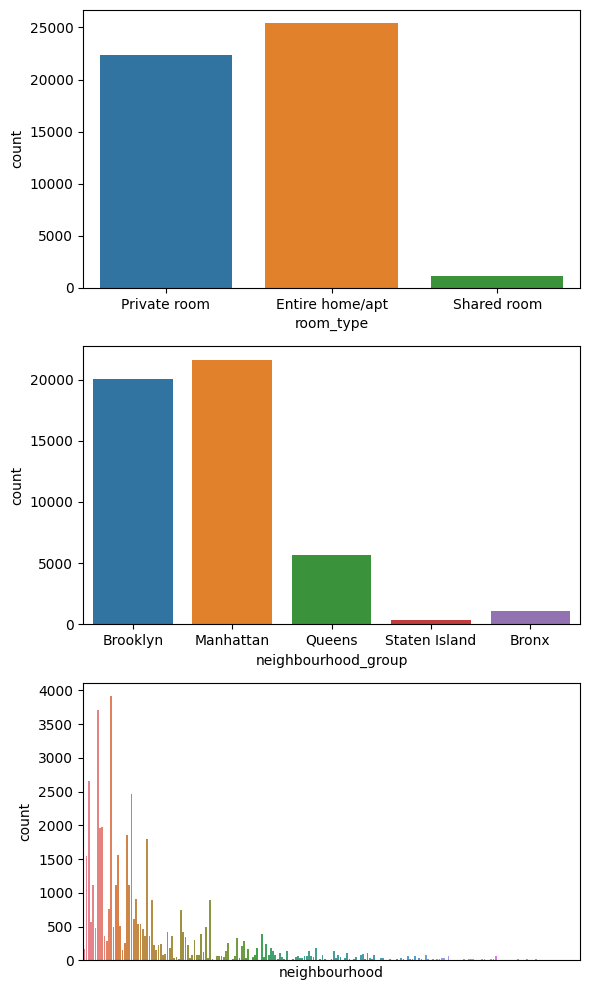

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, ax = plt.subplots(3, 1, figsize = (6, 10))
sns.countplot(ax= ax[0], data = df, x = "room_type", hue='room_type')
sns.countplot(ax = ax[1], data = df, x = "neighbourhood_group", hue='neighbourhood_group')
sns.countplot(ax = ax[2], data = df, x = 'neighbourhood', hue='neighbourhood')
plt.xticks(rotation=90, fontsize=6)

ax[2].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Hide x-axis labels 

plt.tight_layout()
plt.show()


#### Statements 
With the representation of each variable by plotting their histogram, it's possible to determine that:

* ****room_type**** - this variable shows that most listings are for Private room and Entire home/apt, which is expected, as this offers more privacy and comfort to guests.

* ****neighbourhood_group**** - this variable shows a unequal distribution. Most properties are concentrated in Brooklyn and Manhattan, reflecting the higher demand and real estate value in these central areas, as well as their tourist and commercial appeal, compared to Staten Island and Bronx.

* ****neighbourhood**** - the distribution suggests that some neighborhoods are much more popular for Airbnb rentals than others. This could be due to tourist appeal, ease of access to public transportation, or simply the number of available listings. The long tail of the distribution suggests that most neighborhoods have few listings, with demand concentrated in a few highly popular neighborhoods.



**3.2. ANALYSIS OF NUMERICAL VARIABLES**

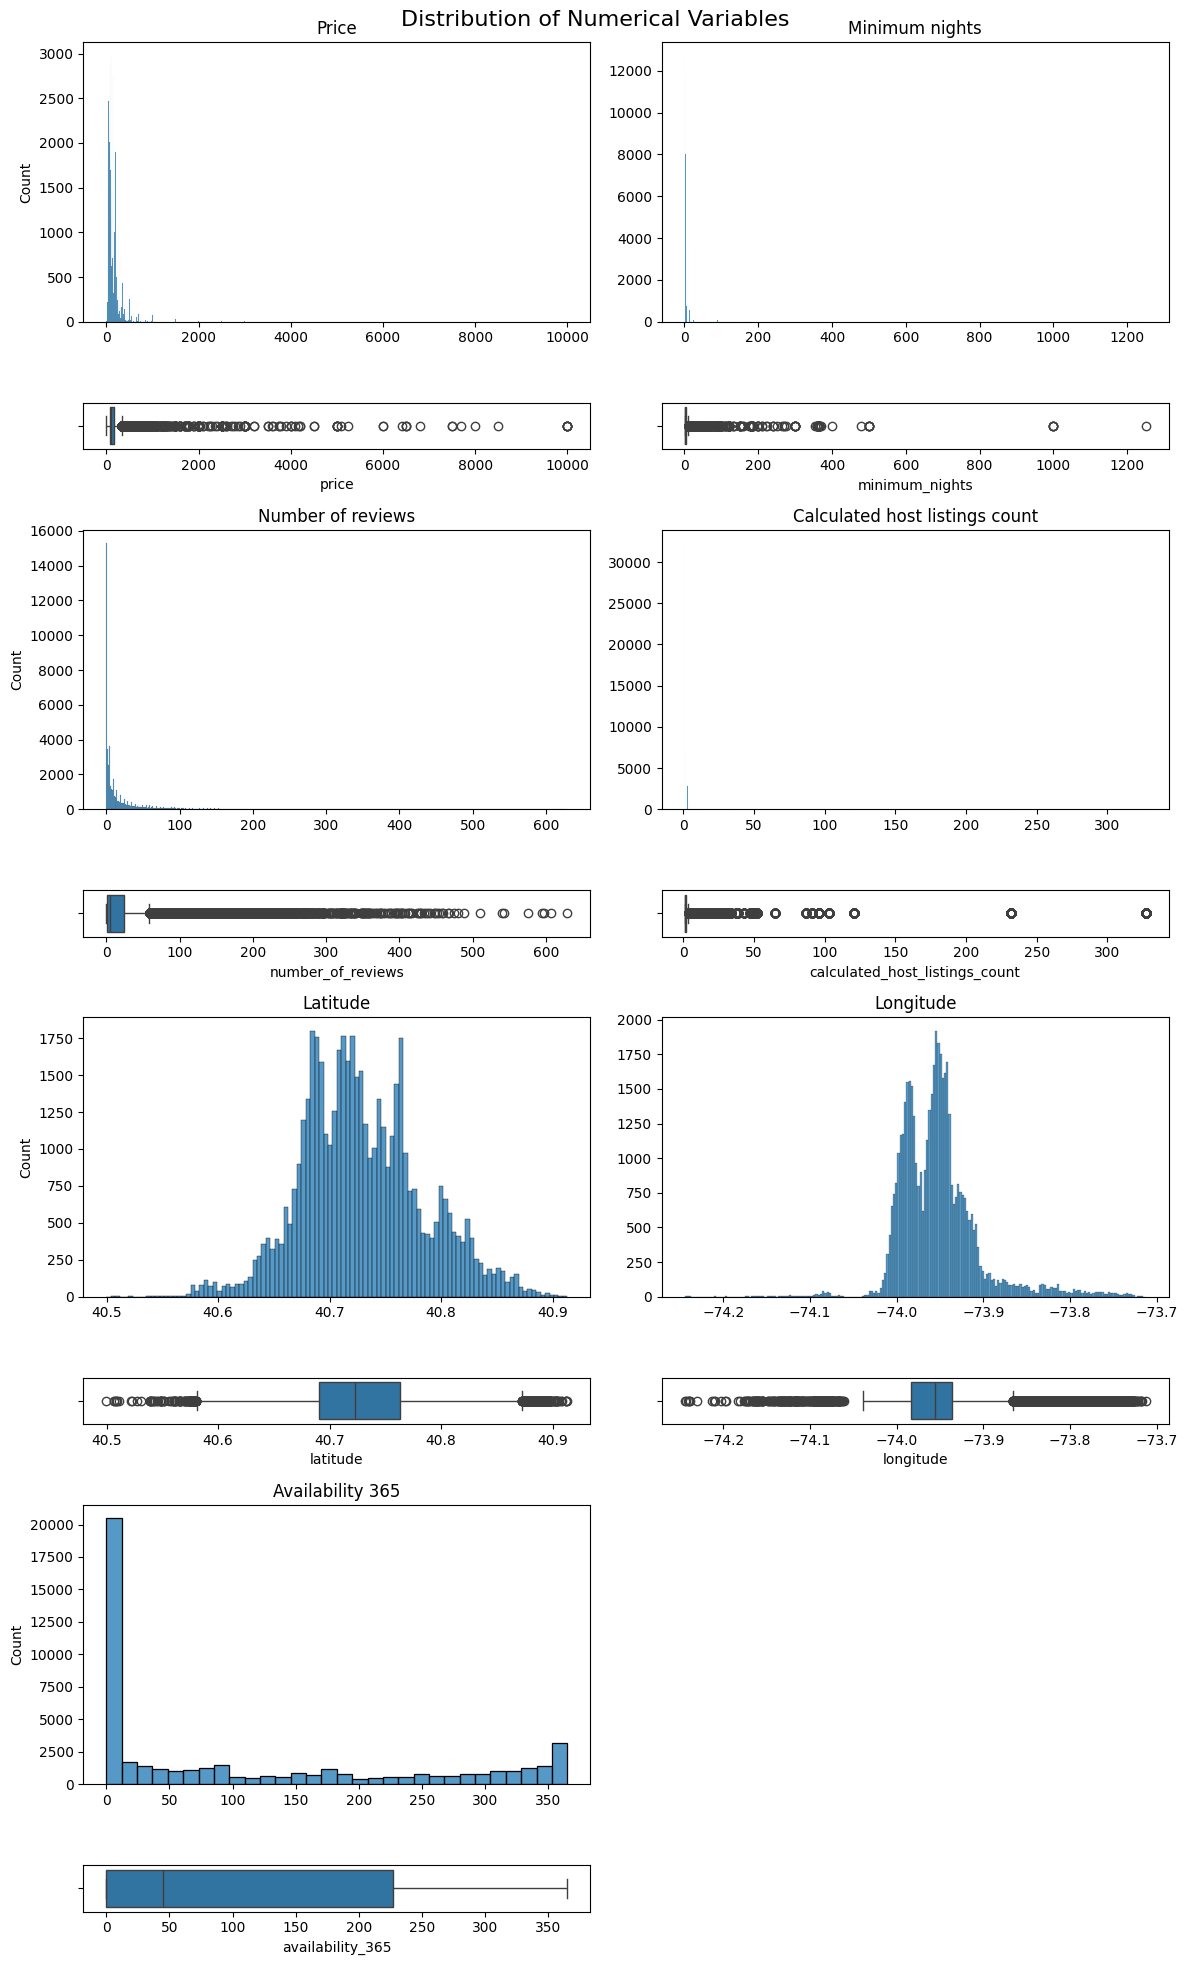

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axis = plt.subplots(8, 2, figsize=(12, 20), gridspec_kw={"height_ratios": [6, 1, 6, 1, 6, 1, 6, 1]})
plt.suptitle('Distribution of Numerical Variables', fontsize=16)

# Create histograms and boxplots for each variable

# Price
sns.histplot(ax=axis[0, 0], data=df, x="price").set(xlabel=None, title="Price")
sns.boxplot(ax=axis[1, 0], data=df, x="price")

# Minimum Nights
sns.histplot(ax=axis[0, 1], data=df, x="minimum_nights").set(xlabel=None, ylabel=None, title="Minimum nights")
sns.boxplot(ax=axis[1, 1], data=df, x="minimum_nights")

# Number of Reviews
sns.histplot(ax=axis[2, 0], data=df, x="number_of_reviews").set(xlabel=None, title="Number of reviews")
sns.boxplot(ax=axis[3, 0], data=df, x="number_of_reviews")

# Calculated Host Listings Count
sns.histplot(ax=axis[2, 1], data=df, x="calculated_host_listings_count").set(xlabel=None, ylabel=None, title="Calculated host listings count")
sns.boxplot(ax=axis[3, 1], data=df, x="calculated_host_listings_count")

# Latitude
sns.histplot(ax=axis[4, 0], data=df, x="latitude").set(xlabel=None, title="Latitude")
sns.boxplot(ax=axis[5, 0], data=df, x="latitude")

# Longitude
sns.histplot(ax=axis[4, 1], data=df, x="longitude").set(xlabel=None, ylabel=None, title="Longitude")
sns.boxplot(ax=axis[5, 1], data=df, x="longitude")

# Availability 365
sns.histplot(ax=axis[6, 0], data=df, x="availability_365").set(xlabel=None, title="Availability 365")
sns.boxplot(ax=axis[7, 0], data=df, x="availability_365")

# Remove the empty subplot
fig.delaxes(axis[7, 1])
fig.delaxes(axis[6, 1])

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


* to have a better visualization of data distribution, I decided to graph a new version with a shorter limit in axis "x".

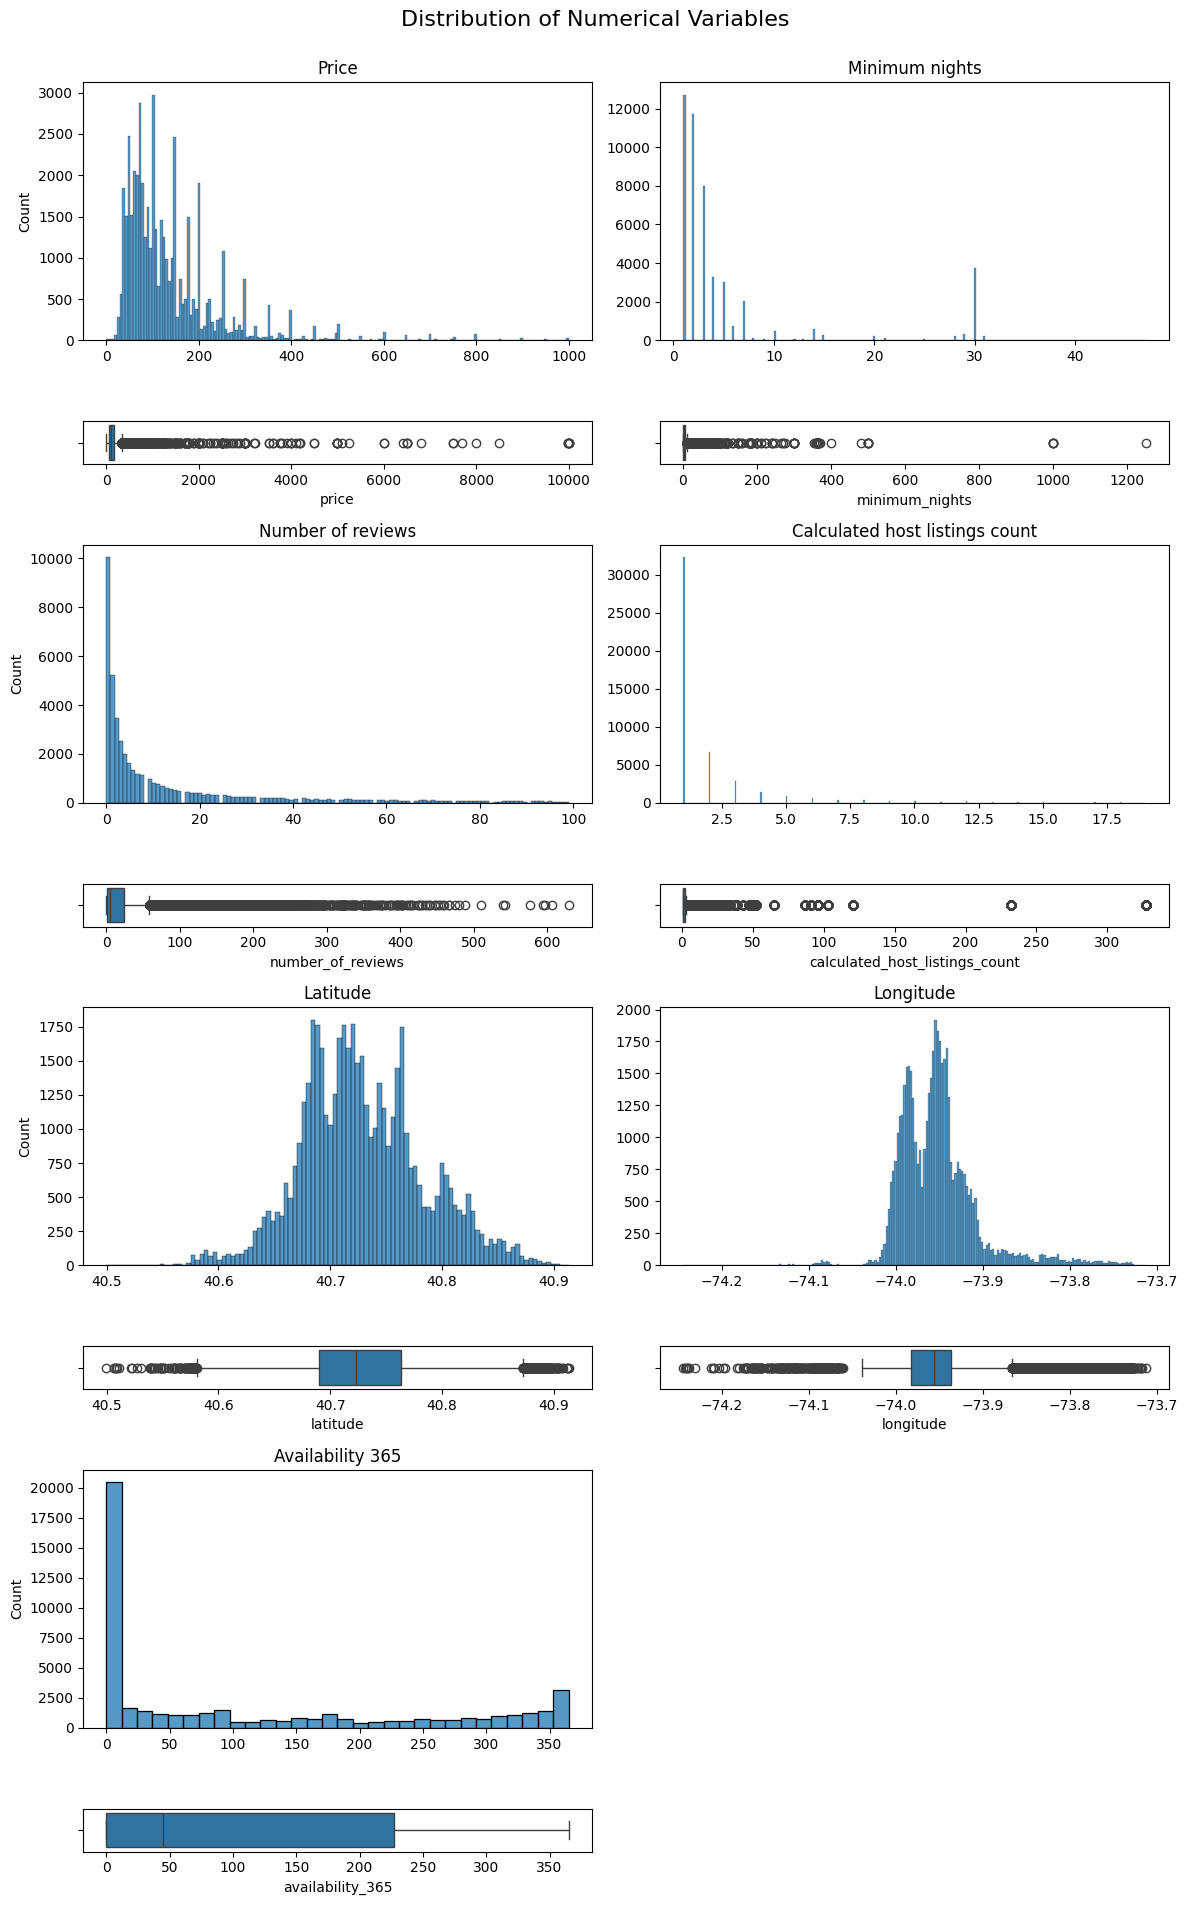

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axis = plt.subplots(8, 2, figsize=(12, 20), gridspec_kw={"height_ratios": [6, 1, 6, 1, 6, 1, 6, 1]})
plt.suptitle('Distribution of Numerical Variables', fontsize=16)

# Create histograms and boxplots for each variable

# Price
sns.histplot(ax=axis[0, 0], data=df[df["price"] < 1000], x="price").set(xlabel=None, title="Price")
sns.boxplot(ax=axis[1, 0], data=df, x="price")

# Minimum Nights
sns.histplot(ax=axis[0, 1], data=df[df["minimum_nights"] < 50], x="minimum_nights").set(xlabel=None, ylabel=None, title="Minimum nights")
sns.boxplot(ax=axis[1, 1], data=df, x="minimum_nights")

# Number of Reviews
sns.histplot(ax=axis[2, 0], data=df[df["number_of_reviews"] < 100], x="number_of_reviews").set(xlabel=None, title="Number of reviews")
sns.boxplot(ax=axis[3, 0], data=df, x="number_of_reviews")

# Calculated Host Listings Count
sns.histplot(ax=axis[2, 1], data=df[df["calculated_host_listings_count"] < 20], x="calculated_host_listings_count").set(xlabel=None, ylabel=None, title="Calculated host listings count")
sns.boxplot(ax=axis[3, 1], data=df, x="calculated_host_listings_count")

# Latitude
sns.histplot(ax=axis[4, 0], data=df, x="latitude").set(xlabel=None, title="Latitude")
sns.boxplot(ax=axis[5, 0], data=df, x="latitude")

# Longitude
sns.histplot(ax=axis[4, 1], data=df, x="longitude").set(xlabel=None, ylabel=None, title="Longitude")
sns.boxplot(ax=axis[5, 1], data=df, x="longitude")

# Availability 365
sns.histplot(ax=axis[6, 0], data=df, x="availability_365").set(xlabel=None, title="Availability 365")
sns.boxplot(ax=axis[7, 0], data=df, x="availability_365")

# Remove the empty subplot
fig.delaxes(axis[6, 1])
fig.delaxes(axis[7, 1])

# Adjust the layout to prevent overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

# Show the plot
plt.show()


#### Statements

 
* **Price:** this variable is central to modeling rental cost and helps identify luxury or economy listings; most listings are concentrated in lower price ranges, while only a few properties charge very high rates. This may indicate that the Airbnb market in New York is accessible for different budgets, though with some luxury or exclusive properties.

* **Minimum Nights:** this variable helps differentiate between posts geared towards short and long stays; the distribution shows that most hosts do not require a very high minimum number of nights.

* **Number of Reviews:** this variable indicates the popularity and frequency of use of properties; most listings have few reviews, suggesting that many properties may be new or have low popularity. However, listings with many reviews may indicate high-demand properties.

* **Calculated Host Listings Count:** this variable reflects the level of experience or professionalism of hosts, differentiating casual hosts from multi-property managers; most hosts have only one or a few properties, indicating that the Airbnb market in New York is largely dominated by small hosts. However, there are a few large hosts with many listings, suggesting the presence of professionals in the market.

* **Latitude and longitude:** geographic location tends to be one of the main factors influencing price and demand, especially in large cities. Properties in central areas or near tourist attractions tend to be more expensive. The histogram shows that most Airbnb listings in New York are in central or popular areas. This analysis suggests that this variable may be important in predicting price and popularity, as listings closer to the center or high-demand areas are likely to be more valuable.

* **Availability_365:** the bimodal distribution of availability suggests that most properties have low availability, pointing to occasional rentals, while a smaller subset remains open year-round, likely managed by professional hosts. So, this indicates a mix of dedicated hosts and potentially seasonal or inactive listings.

***STEP 4: ANALYSIS OF MULTIVARIATE VARIABLES***

Multivariate analysis also allows combining the class with several predictors at the same time to enrich the analysis.

**4.1 NUMERICAL-NUMERICAL ANALYSIS**

Since we are faced with an Airbnb dataset, the variable of interest for this bivariate analysis could be **price**, as it is a ***continuous numerical*** variable that is ***central*** to the context of accommodation. Analyzing how price varies in relation to other variables can help us understand which factors most influence rental prices.

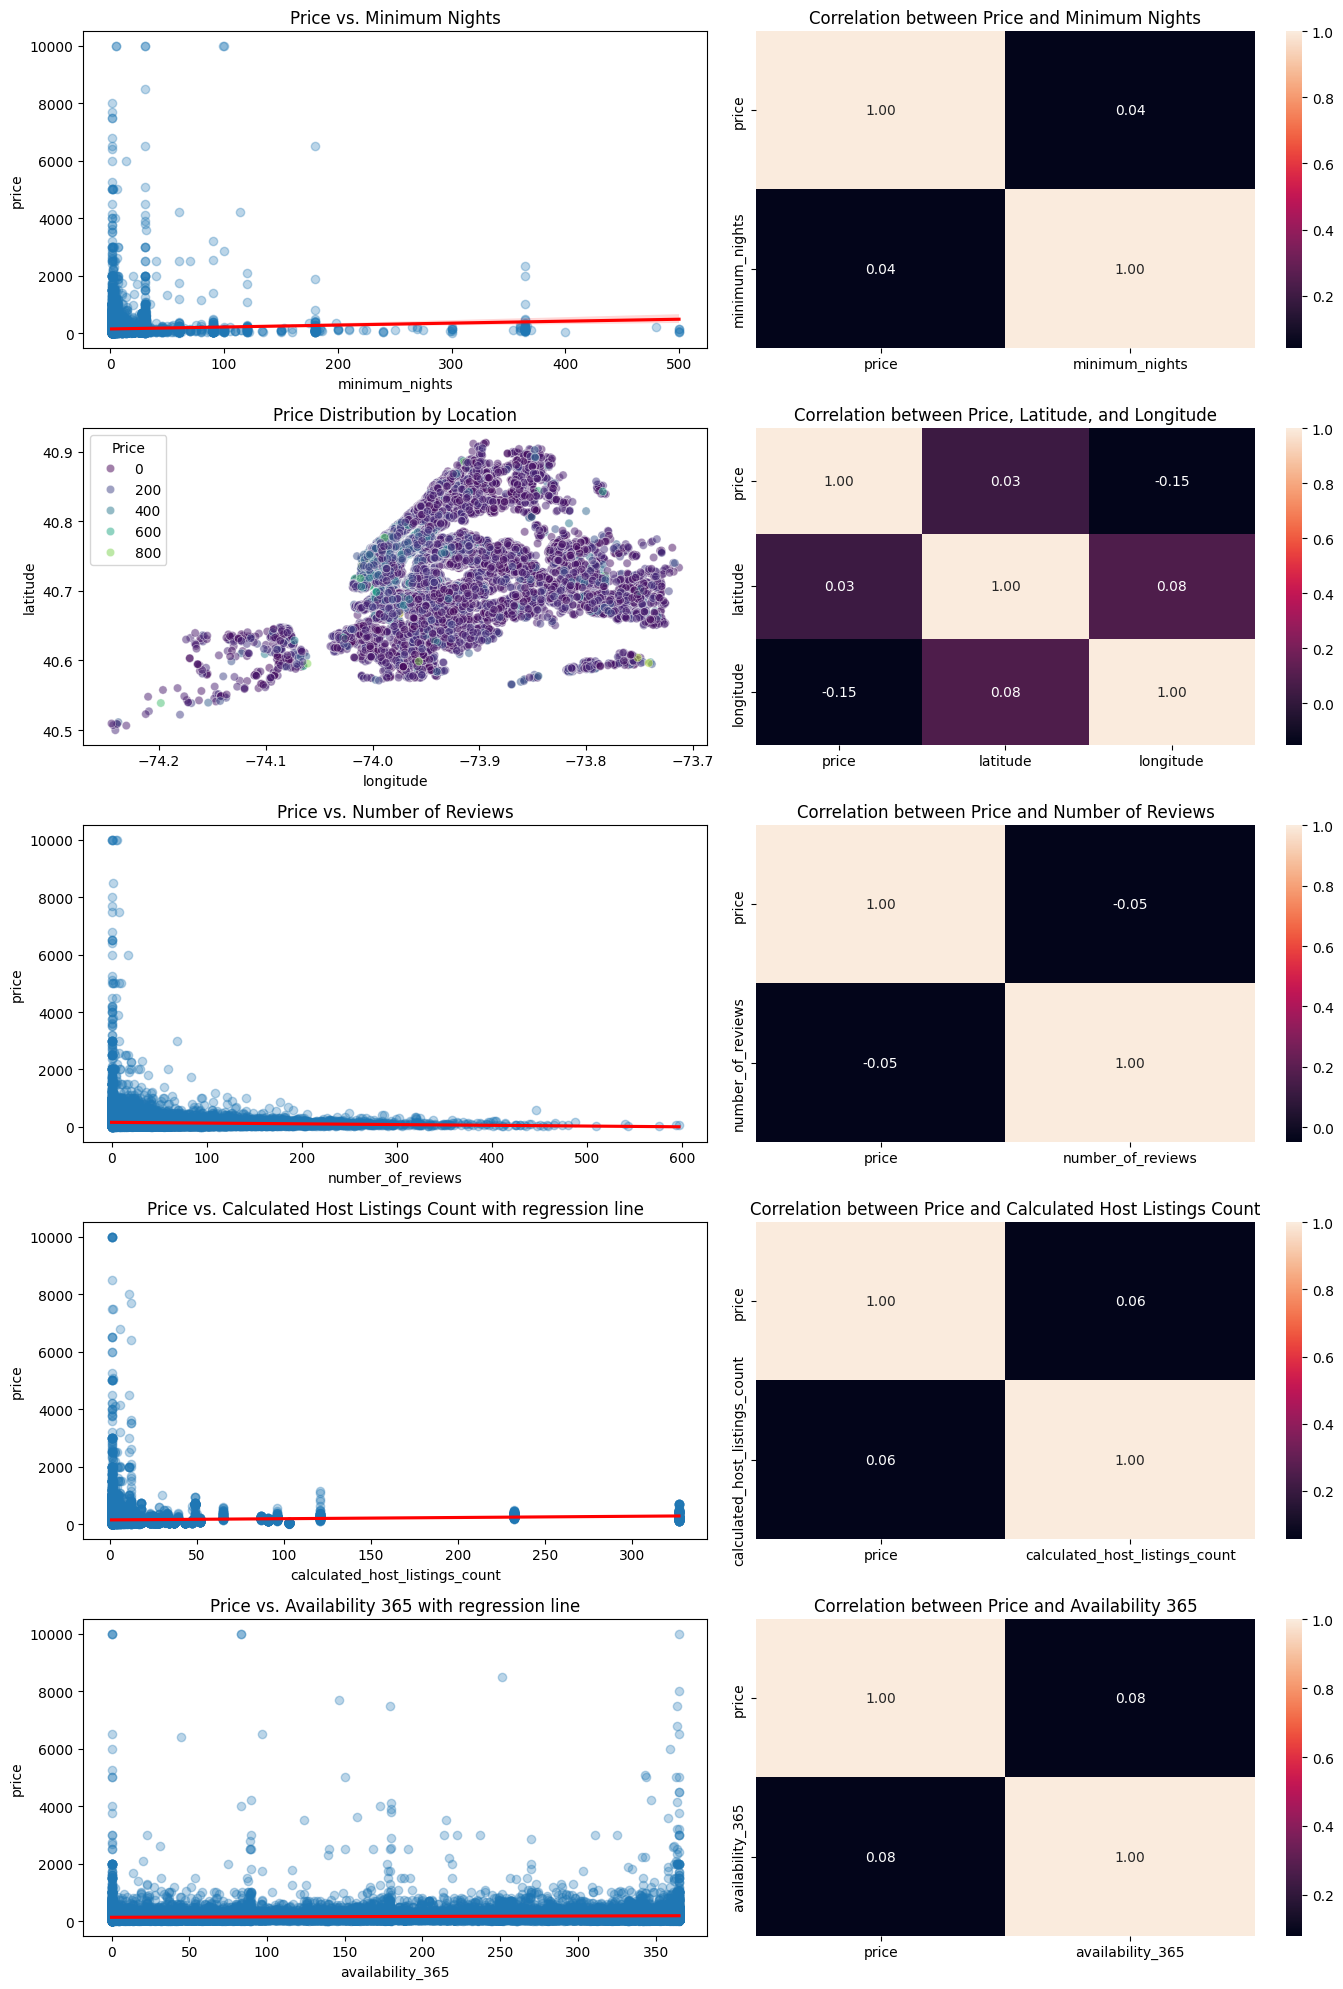

In [ ]:
plt.figure(figsize=(14, 20))  # Size adjustment to accommodate more subplots

# 1. Scatter plot: Price vs. Minimum Nights with regression line
plt.subplot(5, 2, 1)
sns.regplot(data=df[df["minimum_nights"] < 600], x='minimum_nights', y='price', 
            scatter_kws={'alpha':0.3}, line_kws={"color":"red"})
plt.title('Price vs. Minimum Nights')

# 2. Correlation Heatmap for Price and Minimum Nights
plt.subplot(5, 2, 2)
corr_min_nights_price = df[['price', 'minimum_nights']].corr()
sns.heatmap(corr_min_nights_price, annot=True, fmt=".2f", cbar=True)
plt.title('Correlation between Price and Minimum Nights')

# 3. Scatter plot: Price vs. Location (Latitude and Longitude)
plt.subplot(5, 2, 3)
sns.scatterplot(data=df[df["price"] < 1000], x='longitude', y='latitude', hue='price', palette='viridis', alpha=0.5)
plt.title('Price Distribution by Location')
plt.legend(title='Price')

# 4. Correlation Heatmap for Latitude and Longitude
plt.subplot(5, 2, 4)
corr_lat_long_price = df[['price', 'latitude', 'longitude']].corr()
sns.heatmap(corr_lat_long_price, annot=True, fmt=".2f", cbar=True)
plt.title('Correlation between Price, Latitude, and Longitude')

# 5. Scatter plot: Price vs. Number of Reviews with regression line
plt.subplot(5, 2, 5)
sns.regplot(data=df[df["number_of_reviews"] < 600], x='number_of_reviews', y='price', 
            scatter_kws={'alpha':0.3}, line_kws={"color":"red"})
plt.title('Price vs. Number of Reviews')

# 6. Correlation Heatmap for Price and Number of Reviews
plt.subplot(5, 2, 6)
corr_reviews_price = df[['price', 'number_of_reviews']].corr()
sns.heatmap(corr_reviews_price, annot=True, fmt=".2f", cbar=True)
plt.title('Correlation between Price and Number of Reviews')

# 7. Scatter plot: Price vs. Calculated Host Listings Count with regression line
plt.subplot(5, 2, 7)
sns.regplot(data=df[df["calculated_host_listings_count"] < 600], x='calculated_host_listings_count', y='price', 
            scatter_kws={'alpha':0.3}, line_kws={"color":"red"})
plt.title('Price vs. Calculated Host Listings Count with regression line')

# 8. Correlation Heatmap for Price and Calculated Host Listings Count
plt.subplot(5, 2, 8)
corr_calculated_host_listings_price = df[['price', 'calculated_host_listings_count']].corr()
sns.heatmap(corr_calculated_host_listings_price, annot=True, fmt=".2f", cbar=True)
plt.title('Correlation between Price and Calculated Host Listings Count')

# 9. Scatter plot: Price vs. Availability_365 with regression line
plt.subplot(5, 2, 9)
sns.regplot(data=df, x='availability_365', y='price', 
            scatter_kws={'alpha':0.3}, line_kws={"color":"red"})
plt.title('Price vs. Availability 365 with regression line')

# 10. Correlation Heatmap for Price and Availability 365
plt.subplot(5, 2, 10)
corr_availability_price = df[['price', 'availability_365']].corr()
sns.heatmap(corr_availability_price, annot=True, fmt=".2f", cbar=True)
plt.title('Correlation between Price and Availability 365')

# Layout adjustment
plt.tight_layout()
plt.show()



#### Statements

**Price vs. Minimum Nights:**  
* Graphical Analysis: It can be seen that higher prices may appear for low minimum_nights values, but there is a large concentration of low prices and low average minimum nights. This suggests that price is not significantly affected by the minimum number of nights required by the host, as there is no clear pattern of price increasing with increasing minimum nights.
* Correlation: The correlation between price and minimum_nights is very weak (0.04), indicating almost no linear relationship between price and minimum number of nights required.
* There is no relation between the **price** and **minimum nights**.

**Price vs. Distribution by Location (Latitude vs. Longitude):** 
* The areas with the highest prices seem to be concentrated in the central region (where lighter colored dots represent higher values).
* The southernmost and most remote areas tend to have lower prices, which is common in cities where the urban center is valued.
* The geographic distribution confirms that location has a direct impact on prices, with central areas, close to points of interest, charging significantly higher prices.
* There is a slight negative correlation between **price** and **longitude**, suggesting that areas further west (closer to Manhattan) may have slightly higher prices. However, this ***correlation is very weak*** (-0.15).

**Price vs. Number of Reviews:** 
* Graphical Analysis: The highest prices tend to be concentrated in listings with few reviews, but there is a large dispersion in the lowest prices. This suggests that the number of reviews does not significantly influence the price.
* Correlation: The correlation between price and number_of_reviews is slightly negative (-0.05), indicating a very weak and inverse relationship between price and number of reviews; so, lower-priced properties may be more popular or affordable, thus accumulating more reviews.
* There is no relation between the **price** and the **number of reviews**.

**Price vs. Calculated Host Listings Count:**
* Graphical Analysis: Most of the high prices are associated with listings with few properties from the same host, but there are still some more expensive listings with higher host listings. This suggests that the number of listings a host has is not a decisive factor in price.
* Correlation: The correlation between price and calculated_host_listings_count is slightly positive (0.06), indicating a very weak relationship between price and the number of listings a host has.

**Price vs. Availability 365:**
* Graphical Analysis: It can be seen that high prices appear across the entire availability spectrum (from 0 to 365 days). This indicates that annual availability does not have a direct impact on price.
* Correlation: The correlation between price and availability_365 is slightly positive (0.08), suggesting a very weak relationship between price and annual availability.


**4.2 CATEGORICAL-CATEGORICAL ANALYSIS**


* **Categorical variables in analysis:** 

    * room_type
    * neighbourhood
    * neighbourhood_group

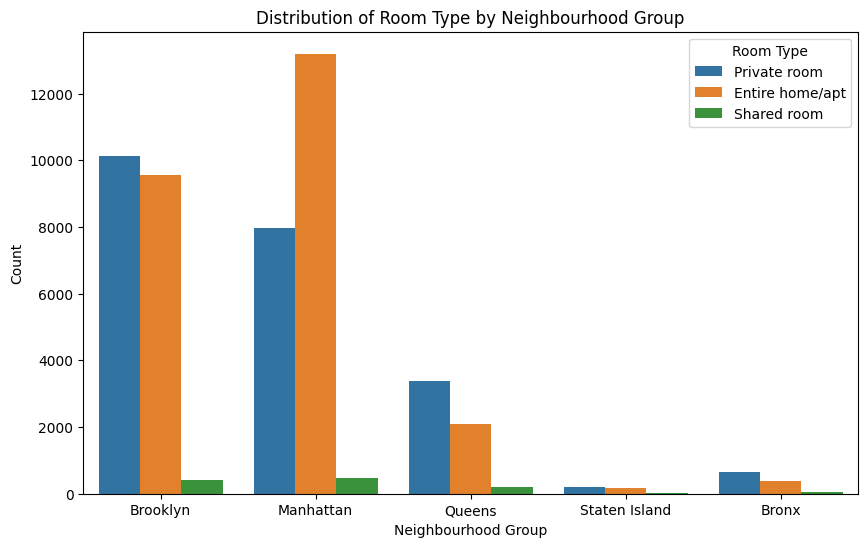

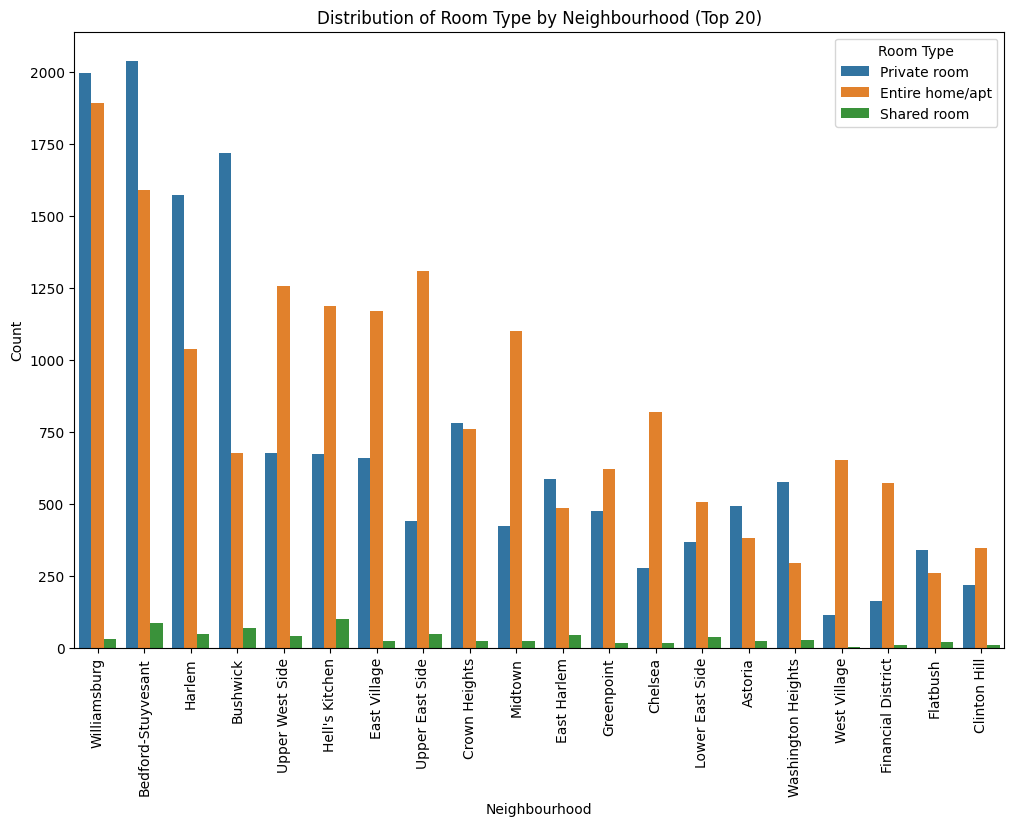

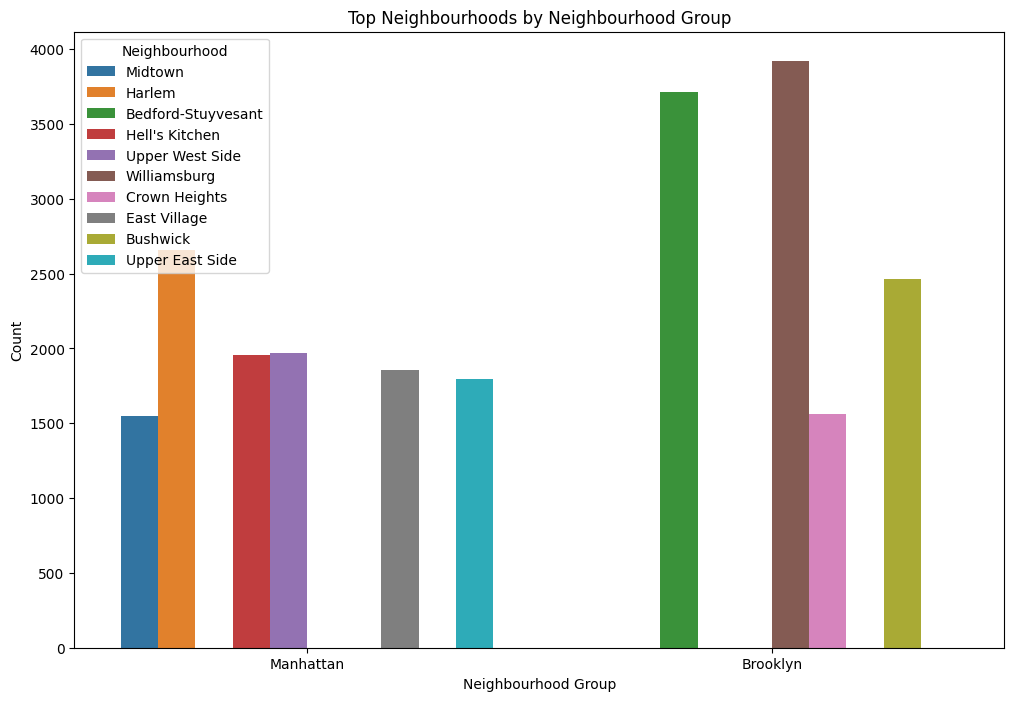

In [13]:
# 1. Countplot: Neighbourhood Group vs. Room Type
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='neighbourhood_group', hue='room_type')
plt.title('Distribution of Room Type by Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Count')
plt.legend(title='Room Type')
plt.show()

# 2. Countplot: Neighbourhood vs. Room Type (focusing on individual neighbourhoods)
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='neighbourhood', hue='room_type', order=df['neighbourhood'].value_counts().index[:20])
plt.title('Distribution of Room Type by Neighbourhood (Top 20)')
plt.xlabel('Neighbourhood')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.legend(title='Room Type')
plt.show()

# 3. Countplot: Neighbourhood Group vs. Neighbourhood (top 10 neighbourhoods per group)
# Limiting to the top neighbourhoods in each group for clarity
top_neighbourhoods = df['neighbourhood'].value_counts().index[:10]
filtered_data = df[df['neighbourhood'].isin(top_neighbourhoods)]

plt.figure(figsize=(12, 8))
sns.countplot(data=filtered_data, x='neighbourhood_group', hue='neighbourhood')
plt.title('Top Neighbourhoods by Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Count')
plt.legend(title='Neighbourhood', loc='upper left')
plt.show()



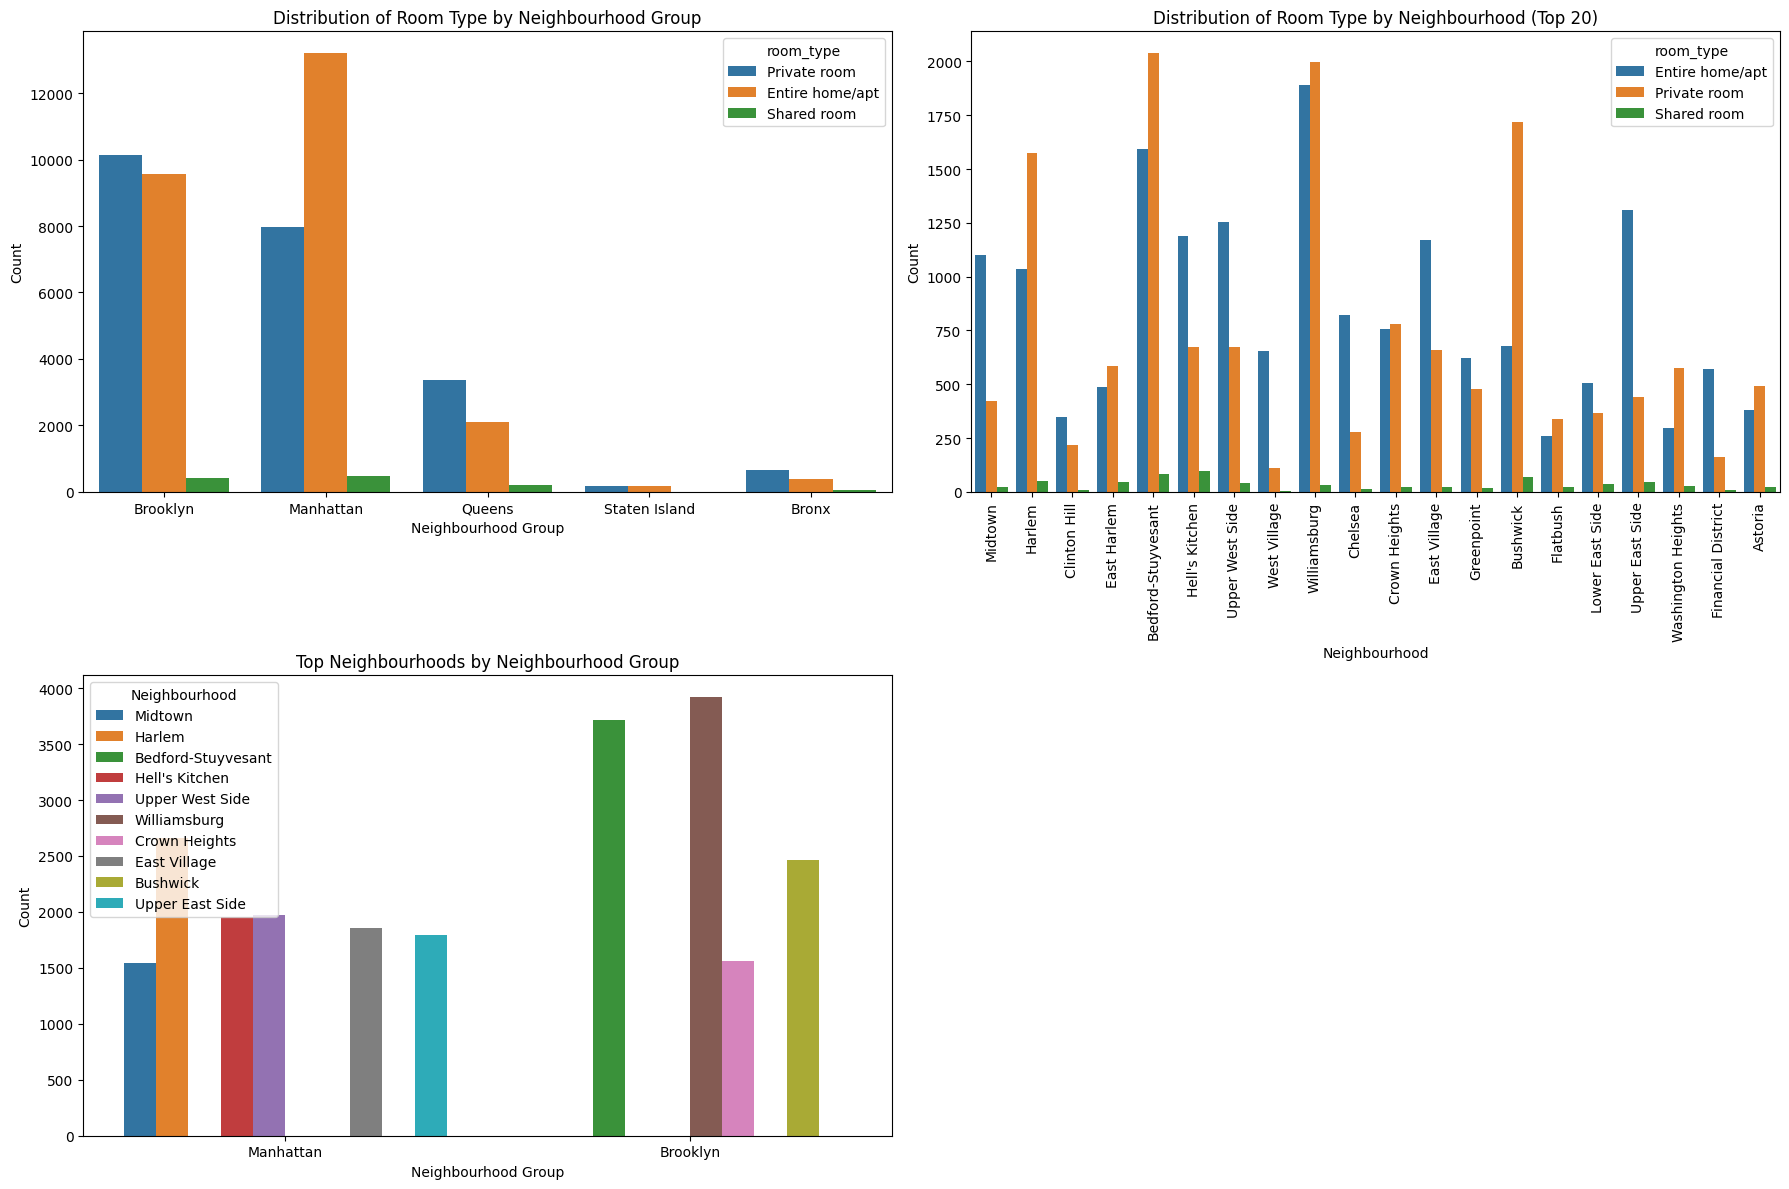

In [ ]:
# ANOTHER WAY TO PERFORME THE GRAPHS 

# Create figure and axes with a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Neighbourhood Group vs Room Type
sns.countplot(ax=axes[0, 0], data=df, x='neighbourhood_group', hue='room_type')
axes[0, 0].set_title('Distribution of Room Type by Neighbourhood Group')
axes[0, 0].set_xlabel('Neighbourhood Group')
axes[0, 0].set_ylabel('Count')

# 2. Neighbourhood vs Room Type (top 20 bairros)
top_neighbourhoods = df['neighbourhood'].value_counts().index[:20]
filtered_data_1 = df[df['neighbourhood'].isin(top_neighbourhoods)]
sns.countplot(ax=axes[0, 1], data=filtered_data_1, x='neighbourhood', hue='room_type')
axes[0, 1].set_title('Distribution of Room Type by Neighbourhood (Top 20)')
axes[0, 1].set_xlabel('Neighbourhood')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=90)  # Rotate for readability

# 3. Neighbourhood Group vs Neighbourhood (top 10 neighborhoods)
top_neighbourhoods_2 = df['neighbourhood'].value_counts().index[:10]
filtered_data_2 = df[df['neighbourhood'].isin(top_neighbourhoods_2)]
sns.countplot(ax=axes[1, 0], data=filtered_data_2, x='neighbourhood_group', hue='neighbourhood')
axes[1, 0].set_title('Top Neighbourhoods by Neighbourhood Group')
axes[1, 0].set_xlabel('Neighbourhood Group')
axes[1, 0].set_ylabel('Count')
axes[1, 0].legend(title='Neighbourhood', loc='upper left')

# another way to eliminate empty graphs
axes[1, 1].set_visible(False)

# Adjust layout for best viewing
plt.tight_layout()
plt.show()


#### Statements

* **Room Type Distribution:** Entire home/apt is more common in tourist areas (especially Manhattan), while Private room is more prevalent in residential neighborhoods in Brooklyn.
* **Rarity of Shared room:** This type of accommodation is less common in all neighborhoods, suggesting a decrease in interest in shared stays.
* **High Demand in Popular Areas:** Neighborhoods such as Midtown and Williamsburg have a significant concentration of listings, reflecting their popularity and potential for short-term rentals.


#### From string to numerical transformation -> json saving

In [ ]:
# Generic function to factorize, save mapping and add column to DataFrame
def factorize_and_save(df, column_name, json_filename):
    # Factorizes the column, obtaining unique and encoded values
    factorized_values, unique_values = pd.factorize(df[column_name])
    
    # Creates the mapping dictionary
    parsing_dict = {str(unique_values[i]): int(factorized_values[factorized_values == i][0]) for i in range(len(unique_values))}
    
    # Save mapping dictionary to JSON
    with open(json_filename, "w") as f:
        json.dump(parsing_dict, f)
    
    # Add the factored column to the DataFrame
    df[column_name + "_n"] = factorized_values

# Applying the function to the columns 'neighbourhood', 'neighbourhood_group' and 'room_type'
factorize_and_save(df, "neighbourhood", "neighbourhood_n.json")
factorize_and_save(df, "neighbourhood_group", "neighbourhood_group_n.json")
factorize_and_save(df, "room_type", "room_type_n.json")


In [39]:
df_n = df.copy()
df_n.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_n,neighbourhood_group_n,room_type_n
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365,0,0,0
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355,1,1,1
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365,2,1,0
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194,3,0,1
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0,4,1,1


In [ ]:
# --- CODE TO RELOAD AND APPLY MAPPING FROM JSON ---

# Loads JSON mappings and applies them to the DataFrame
with open("neighbourhood_n.json", "r") as f:
    neighbourhood_dict = json.load(f)
df_n["neighbourhood_n"] = df_n["neighbourhood"].map(neighbourhood_dict)

with open("neighbourhood_group_n.json", "r") as f:
    neighbourhood_group_dict = json.load(f)
df_n["neighbourhood_group_n"] = df_n["neighbourhood_group"].map(neighbourhood_group_dict)

with open("room_type_n.json", "r") as f:
    room_type_dict = json.load(f)
df_n["room_type_n"] = df_n["room_type"].map(room_type_dict)


In [41]:
df_n.drop(columns=['neighbourhood_group', 'neighbourhood', 'room_type'], inplace=True)
df_n.head(3)

,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_n,neighbourhood_group_n,room_type_n
0,40.64749,-73.97237,149,1,9,6,365,0,0,0
1,40.75362,-73.98377,225,1,45,2,355,1,1,1
2,40.80902,-73.94190,150,3,0,1,365,2,1,0


#### CORRELATION MATRIX

#### Numerical-Categorical analysis (complete)

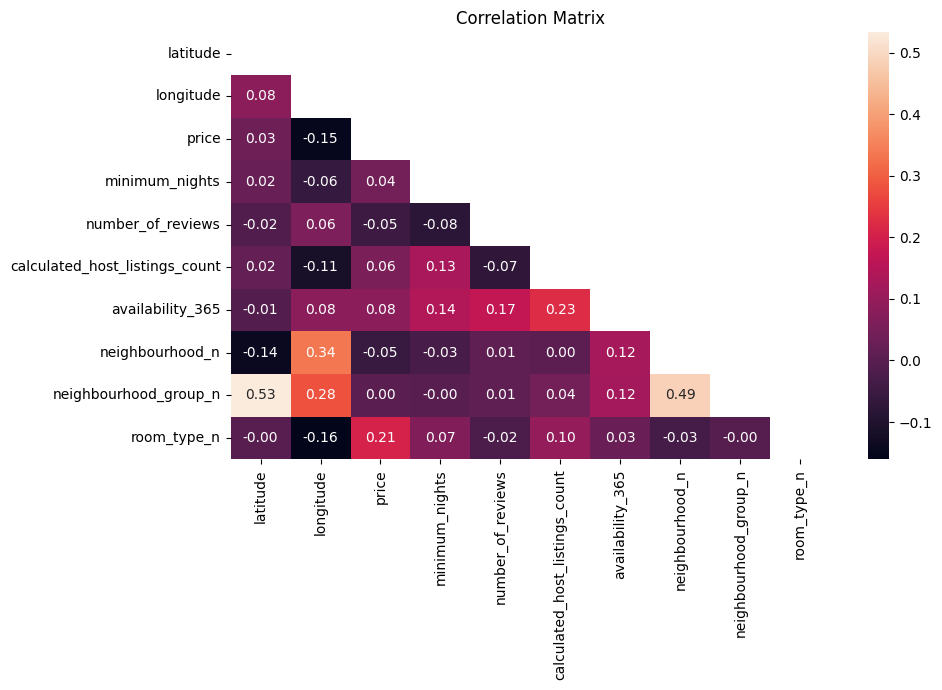

In [16]:
plt.figure(figsize=(10, 7))

sns.heatmap(df_n.corr(), annot=True, fmt=".2f", mask= np.triu(df_n.corr()))
plt.title("Correlation Matrix")

plt.tight_layout()
plt.show()



1. **Price and Room Type**:
   - There’s a positive correlation of 0.21 between `price` and `room_type_n`, indicating that different accommodation types influence price. This suggests that entire homes tend to be more expensive than private or shared rooms.

2. **Calculated Host Listings Count and Availability**:
   - `calculated_host_listings_count` and `availability_365` have a positive correlation of 0.23, suggesting that hosts with multiple listings tend to keep properties available for more days per year, indicating a higher presence of professional hosts.

3. **Neighbourhood Group and Neighbourhood**:
   - `neighbourhood_group_n` and `neighbourhood_n` show a strong positive correlation of 0.49, which is expected, as specific neighborhoods are grouped within larger neighborhood regions. This correlation reflects the dataset’s geographic structure.

4. **Minimum Nights and Availability**:
   - The correlation of 0.14 between `minimum_nights` and `availability_365` is weak, suggesting that, in some areas, higher minimum night requirements may be slightly associated with greater availability.

5. **Reviews and Availability**:
   - A correlation of 0.17 between `number_of_reviews` and `availability_365` suggests that listings available for more days tend to receive more reviews, likely due to more booking opportunities.

6. **Weak Correlation with Price**:
   - `price` shows low correlations with most other variables, except for a slight correlation with `room_type_n` (0.21). This suggests that price may be influenced by other property characteristics not represented in this dataset.

7. **Other Weak Correlations**:
   - Most other variables show very weak or near-zero correlations with each other, indicating low interdependence between categorical and numerical variables in the dataset.



#### Analysing all the variables

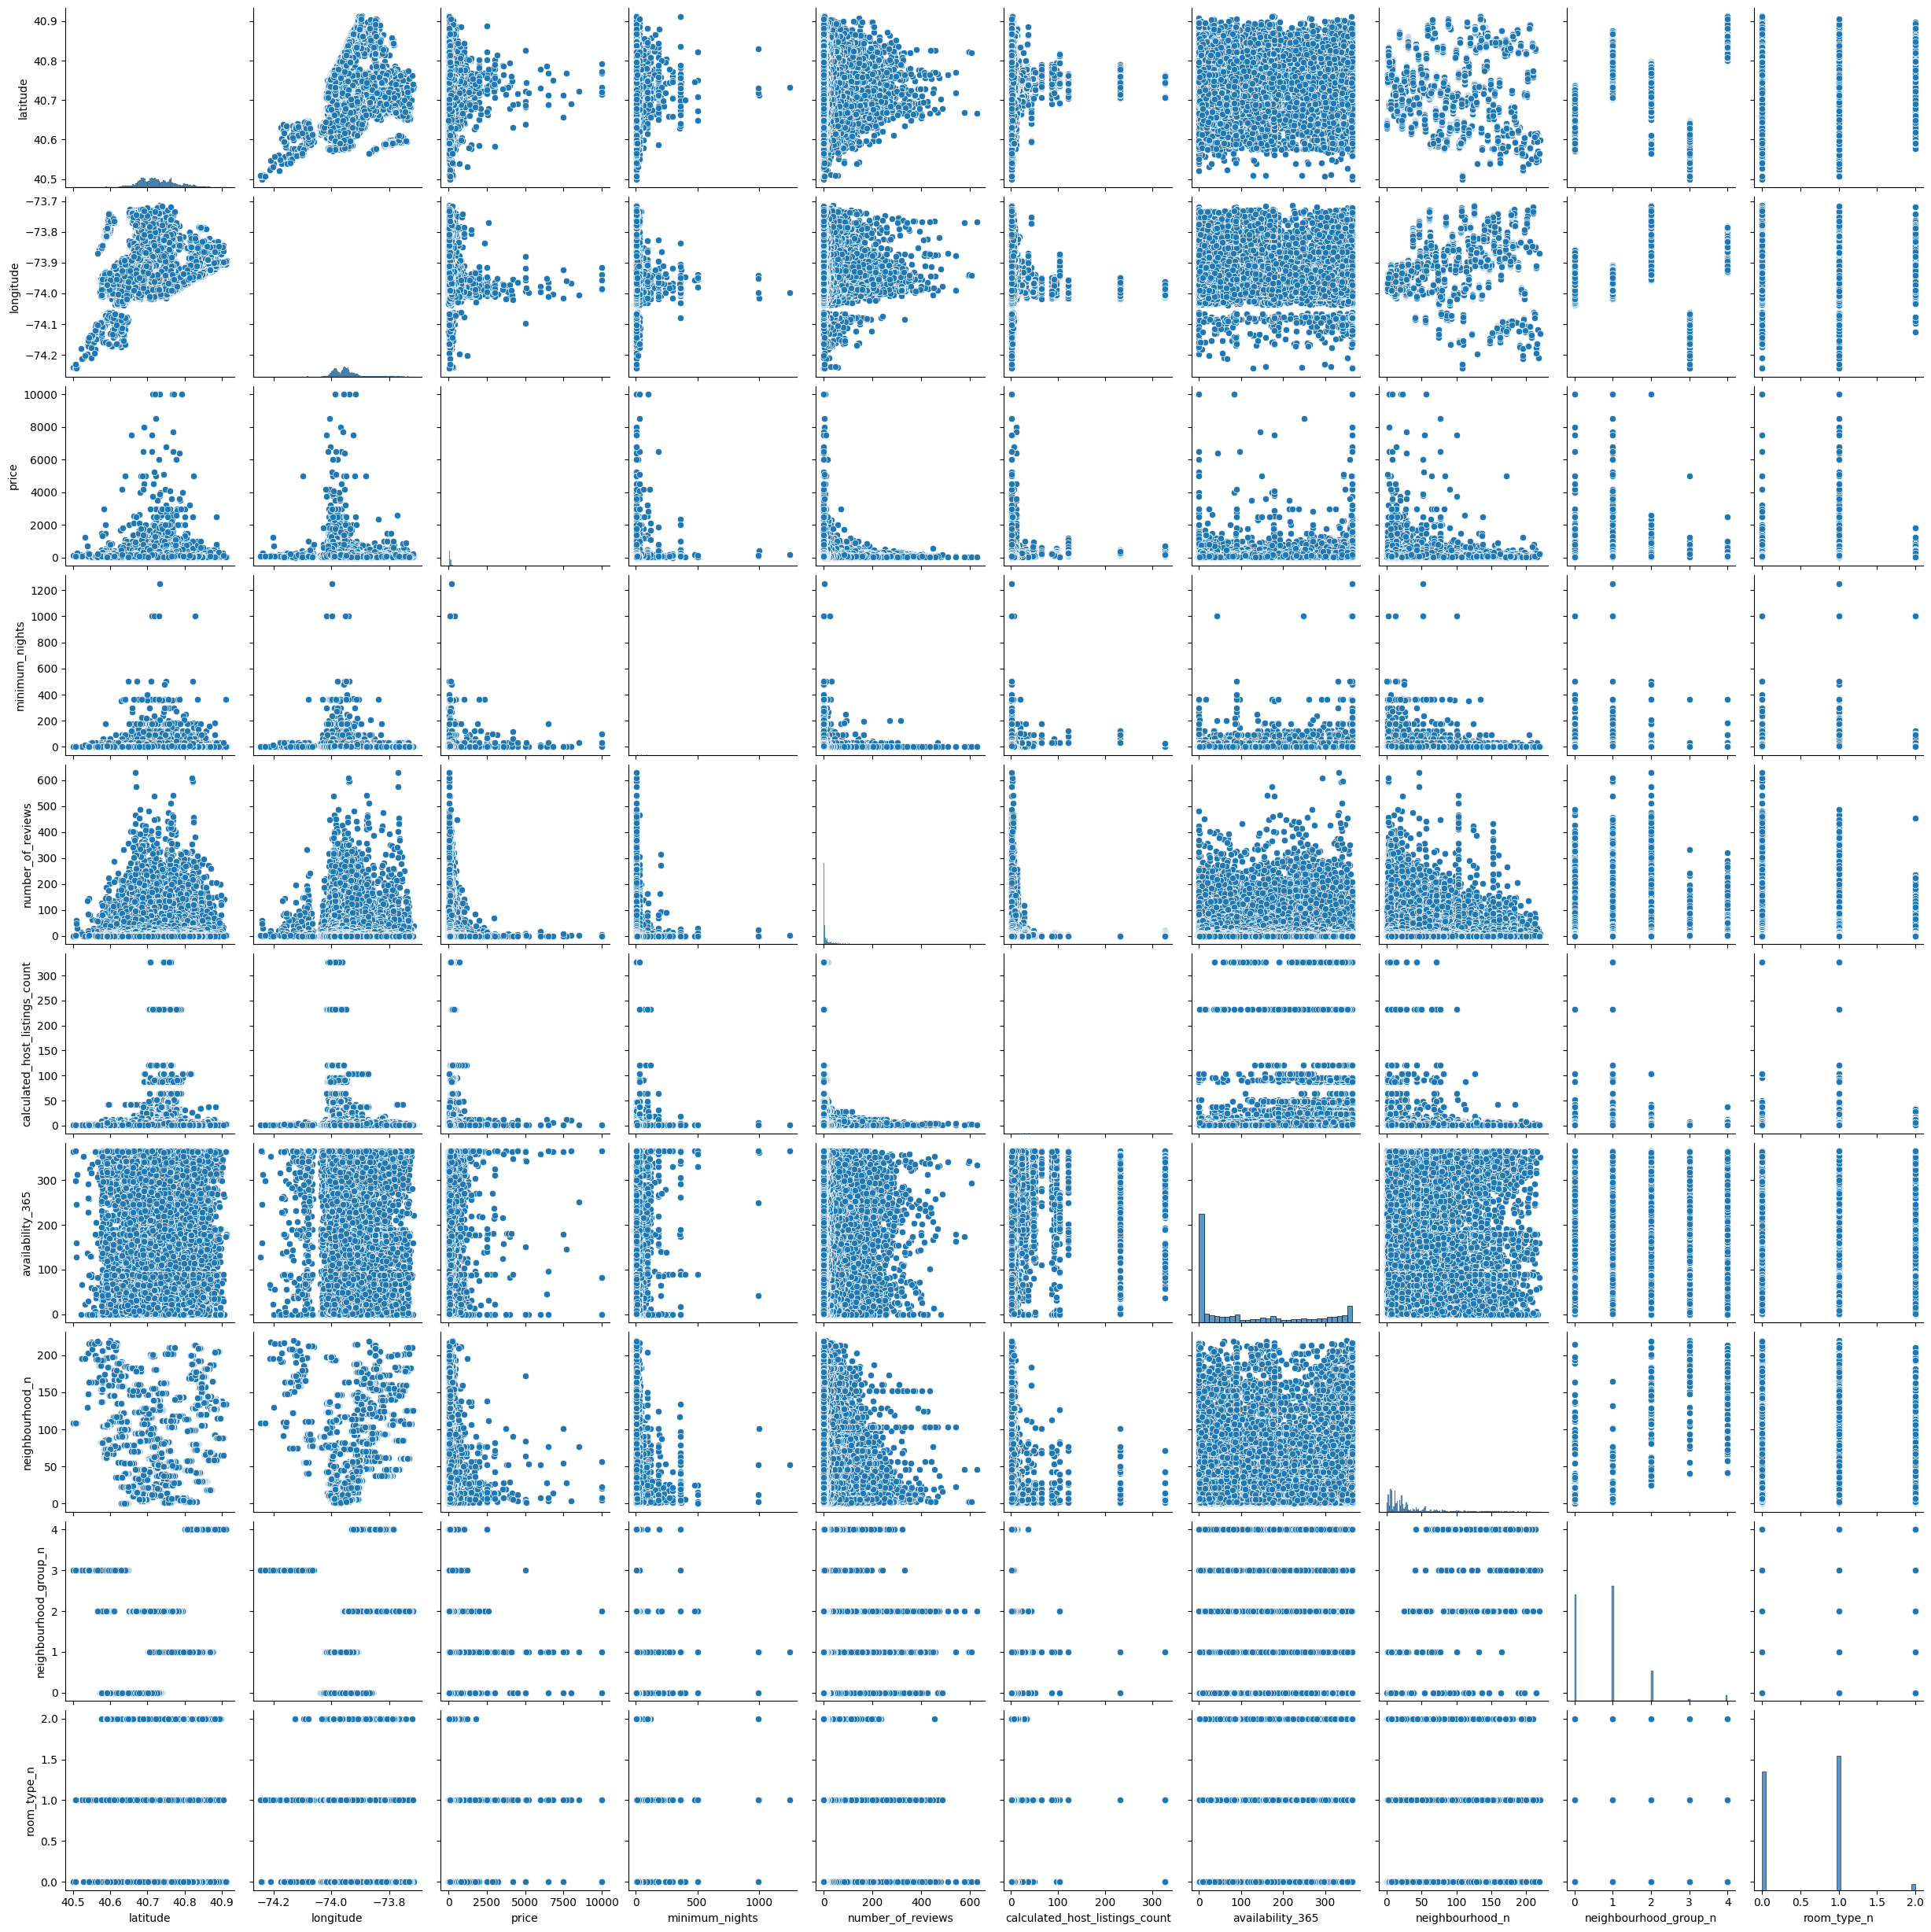

In [17]:
sns.pairplot(data = df_n)

***STEP 5: FEATURE ENGINEERING***

In [42]:
df_stats = df_n.describe()
df_stats

,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_n,neighbourhood_group_n,room_type_n
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,7.143982,112.781327,29.888782,0.786911,0.567113
std,0.054530,0.046157,240.154170,20.510550,44.550582,32.952519,131.622289,34.676634,0.844386,0.541249
min,40.499790,-74.244420,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,1.000000,0.000000,7.500000,0.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,1.000000,45.000000,19.000000,1.000000,1.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.000000,227.000000,37.000000,1.000000,1.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,327.000000,365.000000,220.000000,4.000000,2.000000


Based on the descriptive statistics, it is possible to observe that:
* **mean-** The mean is affected by extremely high values ​​in all variables, suggesting that the data has many outliers;

* **Standard deviation-** The high variability confirms the presence of outliers, since the standard deviation is very high in relation to the means and central values, which suggests that the data is quite dispersed;

* **min-** The minimum values ​​seem reasonable and reflect the typical behavior of listings with minimum stay requirements and of varying popularity;

* **25%, 50% and 75%-** The quartiles indicate a very uneven distribution, especially in the minimum_nights and calculated_host_listings_count variables, with a large number of values ​​close to the upper limits, probably from large property managers or accommodations with exceptional requirements;

* **max-** The maximum values ​​are unrealistically high, which confirms the presence of extreme outliers that distort the overall metrics.

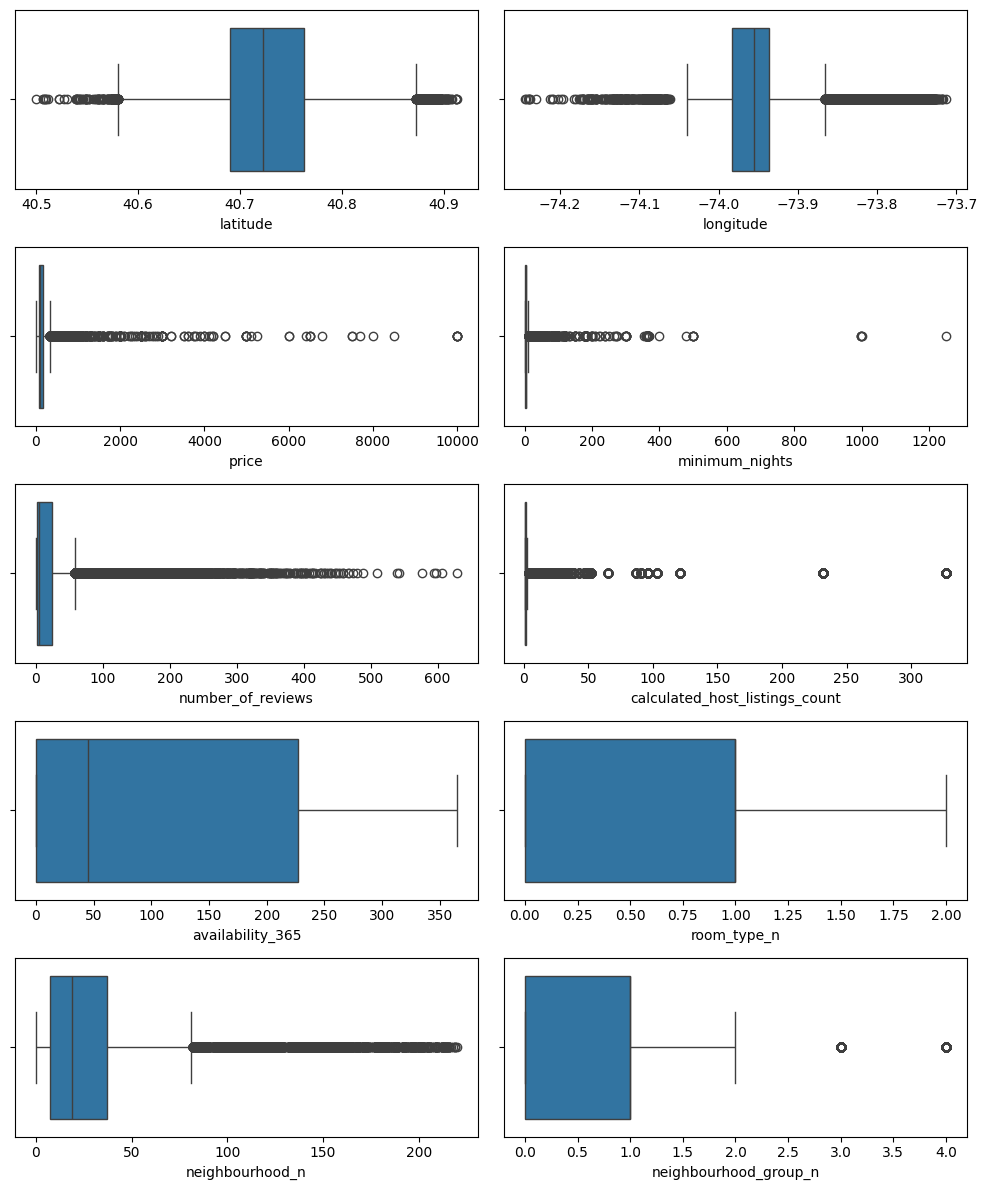

In [19]:
fig, ax = plt.subplots(5, 2, figsize=(10, 12))

sns.boxplot(ax = ax[0,0], data = df_n, x='latitude')
sns.boxplot(ax = ax[0,1], data = df_n, x='longitude')

sns.boxplot(ax = ax[1,0], data = df_n, x='price')
sns.boxplot(ax = ax[1,1], data = df_n, x='minimum_nights')

sns.boxplot(ax = ax[2,0], data = df_n, x='number_of_reviews')
sns.boxplot(ax = ax[2,1], data = df_n, x='calculated_host_listings_count')

sns.boxplot(ax = ax[3,0], data = df_n, x='availability_365')
sns.boxplot(ax = ax[3,1], data = df_n, x='room_type_n')

sns.boxplot(ax = ax[4,0], data = df_n, x='neighbourhood_n')
sns.boxplot(ax = ax[4,1], data = df_n, x='neighbourhood_group_n')

plt.tight_layout()
plt.show()

The following variables are essential for outlier treatment, as they are important for understanding price behavior, listing popularity, and host profiles:
* **minimum_nights** - To better reflect the reality of most stays without excessive requirements.
* **number_of_reviews** - To ensure that highly popular listings do not distort demand analyses.
* **calculated_host_listings_count** - To distinguish between casual hosts and large property managers.

### Outlier Analysis

In [43]:
df_with_outliers = df_n.copy()
df_without_outliers = df_n.copy()

In [ ]:
# This function returns our new df without outliers and the features' limits.  
def remove_outliers(x, feature_name, allow_neg=True):
    q1, q3 = x.quantile([0.25, 0.75])
    iqr = q3 - q1
    upper_lim = q3 + (iqr*2)
    lower_lim = q1 - (iqr*2) if allow_neg else max(0, q1 - (iqr * 2))

    x = x.apply(lambda x: upper_lim if (x > upper_lim) else (lower_lim if (x < lower_lim) else x))
    
    # Relative base directory for 'interim' folder
    base_path = os.path.join('data', 'interim')
    
    # To make sure that the 'processed' directory exists before saving the files
    os.makedirs('./enc', exist_ok=True)

    # Save the limits to a JSON file
    filename = f'/workspaces/RitaViegas---machine-learning-python-template/data/interim/outliers_lims_{feature_name}.json'
    json.dump({'upper_lim': upper_lim, 'lower_lim': lower_lim}, open(filename, 'w'))

    return x



In [30]:
df_without_outliers['minimum_nights'] = remove_outliers(df_without_outliers['minimum_nights'], 'minimum_nights')
df_without_outliers['number_of_reviews'] = remove_outliers(df_without_outliers['number_of_reviews'], 'number_of_reviews')
df_without_outliers['calculated_host_listings_count'] = remove_outliers(df_without_outliers['calculated_host_listings_count'], 'calculated_host_listings_count')


### Missing Values

In [44]:
df_with_outliers.isnull().sum()

latitude                          0
longitude                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0
neighbourhood_n                   0
neighbourhood_group_n             0
room_type_n                       0
dtype: int64

#### Statement
As we can see, there are no missing values.

### Inference of new features


In the context of Exploratory Data Analysis (EDA) for lodging data, creating new variables can be particularly relevant to understanding patterns of behavior, profitability, and popularity. Here are the ones I consider most important:

* **Occupancy rate-** to understand which listings are in highest demand. Since the number of reviews can be an indirect indication of booking frequency, occupancy_rate helps identify listings that are most popular and frequently occupied throughout the year.

* **Revenue estimate-** allows us to get an idea of ​​the financial potential of each listing. In a market analysis context, this variable can help identify the most profitable areas and types of accommodation.

Creating the new variables in both DataFrames (df_with_outliers and df_without_outliers). This way, each DataFrame will have the derived variables, and we can compare the results with and without the outliers.

In [ ]:
# Creating "Occupancy rate" variable
#df_with_outliers['occupancy_rate'] = (df_with_outliers['number_of_reviews'] / df_with_outliers['availability_365']) * 100
#df_without_outliers['occupancy_rate'] = (df_without_outliers['number_of_reviews'] / df_without_outliers['availability_365']) * 100

In [ ]:
#df_with_outliers.drop(columns=['number_of_reviews', 'availability_365'], inplace=True)
#df_without_outliers.drop(columns=['number_of_reviews', 'availability_365'], inplace=True)

**Note!!!**
* After a correlation analysis with all variables, I observed that the correlation of this new variable created based on 2 originals is lower than when analyzing the original variables separately. Thus, I decided to remove the new variable from my EDA and proceed with the individual variables.

In [47]:
df_with_outliers.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_n,neighbourhood_group_n,room_type_n
0,40.64749,-73.97237,149,1,9,6,365,0,0,0
1,40.75362,-73.98377,225,1,45,2,355,1,1,1
2,40.80902,-73.94190,150,3,0,1,365,2,1,0
3,40.68514,-73.95976,89,1,270,1,194,3,0,1
4,40.79851,-73.94399,80,10,9,1,0,4,1,1


In [45]:
df_without_outliers.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_n,neighbourhood_group_n,room_type_n
0,40.64749,-73.97237,149,1,9,6,365,0,0,0
1,40.75362,-73.98377,225,1,45,2,355,1,1,1
2,40.80902,-73.94190,150,3,0,1,365,2,1,0
3,40.68514,-73.95976,89,1,270,1,194,3,0,1
4,40.79851,-73.94399,80,10,9,1,0,4,1,1


In [51]:
df_without_outliers.isnull().sum()

latitude                          0
longitude                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0
neighbourhood_n                   0
neighbourhood_group_n             0
room_type_n                       0
dtype: int64

In [ ]:
# IN CASE OF HAVING ANY NULL VALUE:

#def clean_data(df):
    # replace infinite values ​​with NaN
    #df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # fill NaN values ​​with the column mean
    #df.fillna(df.mean(), inplace=True)
    #return df


In [ ]:
#df_with_outliers_clean = clean_data(df_with_outliers)
#print(df_with_outliers_clean.head())

   latitude  longitude  price  minimum_nights  number_of_reviews  \
0  40.64749  -73.97237    149               1                  9   
1  40.75362  -73.98377    225               1                 45   
2  40.80902  -73.94190    150               3                  0   
3  40.68514  -73.95976     89               1                270   
4  40.79851  -73.94399     80              10                  9   

   calculated_host_listings_count  availability_365  neighbourhood_n  \
0                               6               365                0   
1                               2               355                1   
2                               1               365                2   
3                               1               194                3   
4                               1                 0                4   

   neighbourhood_group_n  room_type_n  
0                      0            0  
1                      1            1  
2                      1            0 

In [ ]:
#df_without_outliers_clean = clean_data(df_without_outliers)
#print(df_without_outliers_clean.head())

   latitude  longitude  price  minimum_nights  number_of_reviews  \
0  40.64749  -73.97237    149               1                  9   
1  40.75362  -73.98377    225               1                 45   
2  40.80902  -73.94190    150               3                  0   
3  40.68514  -73.95976     89               1                270   
4  40.79851  -73.94399     80              10                  9   

   calculated_host_listings_count  availability_365  neighbourhood_n  \
0                               6               365                0   
1                               2               355                1   
2                               1               365                2   
3                               1               194                3   
4                               1                 0                4   

   neighbourhood_group_n  room_type_n  
0                      0            0  
1                      1            1  
2                      1            0 

In [52]:
df_with_outliers.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_n,neighbourhood_group_n,room_type_n
0,40.64749,-73.97237,149,1,9,6,365,0,0,0
1,40.75362,-73.98377,225,1,45,2,355,1,1,1
2,40.80902,-73.94190,150,3,0,1,365,2,1,0
3,40.68514,-73.95976,89,1,270,1,194,3,0,1
4,40.79851,-73.94399,80,10,9,1,0,4,1,1


In [53]:
df_without_outliers.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_n,neighbourhood_group_n,room_type_n
0,40.64749,-73.97237,149,1,9,6,365,0,0,0
1,40.75362,-73.98377,225,1,45,2,355,1,1,1
2,40.80902,-73.94190,150,3,0,1,365,2,1,0
3,40.68514,-73.95976,89,1,270,1,194,3,0,1
4,40.79851,-73.94399,80,10,9,1,0,4,1,1


### Split train/test of both Data Frames

In [ ]:
# Function to split data into training and testing
def split(target, df, test_size=0.2, random_state=123):
    """
    Splits a dataframe into training and testing sets.

    Parameters:
    - target: string, target column we want to predict
    - df: DataFrame, the full dataframe we want to split
    - test_size: float, size of the test set
    - random_state: int, sets the seed for reproducibility
    - output_folder: string (optional), folder where the CSV files will be saved. If None, do not save.

    Returns:
    - X_train, X_test, y_train, y_test: training and testing sets
    """
    
    X = df.drop(columns=target)  # Remove target column from features
    y = df[target]  # Set only the target column to y

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    return X_train, X_test, y_train, y_test

# Applying the split function to data with and without outliers
X_train_with_outliers, X_test_with_outliers, y_train_with_outliers, y_test_with_outliers = split(
    target="price",
    df=df_with_outliers
)

X_train_without_outliers, X_test_without_outliers, y_train_without_outliers, y_test_without_outliers = split(
    target="price",
    df=df_without_outliers
)

# Relative base directory to the 'processed' folder
base_path = os.path.join('data', 'processed')

# To make sure that the 'processed' directory exists before saving the files
os.makedirs(base_path, exist_ok=True)

# Export training and testing data to CSV files using relative paths
X_train_with_outliers.to_csv(os.path.join(base_path, 'X_train_with_outliers.csv'), index=False)
X_test_with_outliers.to_csv(os.path.join(base_path, 'X_test_with_outliers.csv'), index=False)
y_train_with_outliers.to_csv(os.path.join(base_path, 'y_train.csv'), index=False)
y_test_with_outliers.to_csv(os.path.join(base_path, 'y_test.csv'), index=False)

X_train_without_outliers.to_csv(os.path.join(base_path, 'X_train_without_outliers.csv'), index=False)
X_test_without_outliers.to_csv(os.path.join(base_path, 'X_test_without_outliers.csv'), index=False)


In [ ]:
# View training and test data for verification (optional)
X_train_with_outliers.head()

,latitude,longitude,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_n,neighbourhood_group_n,room_type_n
9601,40.70178,-73.92829,4,1,1,0,21,0,1
45574,40.81157,-73.94654,3,0,1,51,2,1,1
33996,40.79485,-73.97550,3,28,1,158,8,1,1
11829,40.75997,-73.99265,2,0,1,0,7,1,1
41134,40.67818,-73.92284,1,3,2,0,6,0,0


In [56]:
y_train_with_outliers.head()

9601      98
45574    799
33996    146
11829    250
41134     55
Name: price, dtype: int64

### Normalization

In [ ]:
def normalize_and_save(X_train, X_test, filename):
    """
    Normalizes the data using StandardScaler and saves the scaler for future use.

    Parameters:
    - X_train: DataFrame with the training data
    - X_test: DataFrame with the testing data
    - filename: string, the name of the file to save the scaler

    Returns:
    - X_train_norm: DataFrame with the normalized training data
    - X_test_norm: DataFrame with the normalized testing data
    """

    scaler = StandardScaler()
    scaler.fit(X_train)  # Fit the scaler with training data

    # Applies normalization to training and testing data
    X_train_norm = scaler.transform(X_train)
    X_train_norm = pd.DataFrame(X_train_norm, index=X_train.index, columns=X_train.columns)

    X_test_norm = scaler.transform(X_test)
    X_test_norm = pd.DataFrame(X_test_norm, index=X_test.index, columns=X_test.columns)

    # Saves the scaler for future use
    joblib.dump(scaler, f'./enc/{filename}.sav')

    return X_train_norm, X_test_norm

# Application of the function to normalize data with and without outliers
X_train_with_outliers_norm, X_test_with_outliers_norm = normalize_and_save(
    X_train_with_outliers, X_test_with_outliers, 'normalized_with_outliers'
)

X_train_without_outliers_norm, X_test_without_outliers_norm = normalize_and_save(
    X_train_without_outliers, X_test_without_outliers, 'normalized_without_outliers'
)

# Checking to ensure data has been normalized and scaled correctly
print(X_train_with_outliers_norm.head())
print(X_test_with_outliers_norm.head())


       latitude  longitude  minimum_nights  number_of_reviews  \
9601  -0.499673   0.518943       -0.145443          -0.498466   
45574  1.516461   0.123242       -0.193460          -0.520806   
33996  1.209422  -0.504676       -0.193460           0.104713   
11829  0.568902  -0.876527       -0.241478          -0.520806   
41134 -0.933052   0.637111       -0.289495          -0.453786   

       calculated_host_listings_count  availability_365  neighbourhood_n  \
9601                        -0.185329         -0.857266        -0.254377   
45574                       -0.185329         -0.469367        -0.802789   
33996                       -0.185329          0.344461        -0.629606   
11829                       -0.185329         -0.857266        -0.658470   
41134                       -0.154982         -0.857266        -0.687334   

       neighbourhood_group_n  room_type_n  
9601               -0.931080     0.799402  
45574               0.255707     0.799402  
33996               

### Min-Max Scaling

In [ ]:
def minmax_and_save(X_train, X_test, filename):
    """
    Applies Min-Max Scaling to the data and saves the scaler for future use.

    Parameters:
    - X_train: DataFrame with the training data
    - X_test: DataFrame with the testing data
    - filename: string, the name of the file to save the scaler

    Returns:
    - X_train_minmax: DataFrame with the scaled training data
    - X_test_minmax: DataFrame with the scaled testing data
    """

    scaler = MinMaxScaler()
    scaler.fit(X_train)  # Fit the scaler with training data

    # Apply Min-Max Scaling to training and testing data
    X_train_minmax = scaler.transform(X_train)
    X_train_minmax = pd.DataFrame(X_train_minmax, index=X_train.index, columns=X_train.columns)

    X_test_minmax = scaler.transform(X_test)
    X_test_minmax = pd.DataFrame(X_test_minmax, index=X_test.index, columns=X_test.columns)

    # Saves the scaler for future use
    joblib.dump(scaler, f'./enc/{filename}.sav')

    return X_train_minmax, X_test_minmax

# Applying the function to scale data with and without outliers
X_train_with_outliers_minmax, X_test_with_outliers_minmax = minmax_and_save(
    X_train_with_outliers, X_test_with_outliers, 'minmax_with_outliers'
)

X_train_without_outliers_minmax, X_test_without_outliers_minmax = minmax_and_save(
    X_train_without_outliers, X_test_without_outliers, 'minmax_without_outliers'
)

# Checking to ensure data is scaled correctly
print(X_train_with_outliers_minmax.head())
print(X_test_with_outliers_minmax.head())


       latitude  longitude  minimum_nights  number_of_reviews  \
9601   0.480438   0.594867        0.002402           0.001590   
45574  0.750424   0.560525        0.001601           0.000000   
33996  0.709308   0.506031        0.001601           0.044515   
11829  0.623534   0.473759        0.000801           0.000000   
41134  0.422403   0.605122        0.000000           0.004769   

       calculated_host_listings_count  availability_365  neighbourhood_n  \
9601                         0.000000          0.000000         0.095455   
45574                        0.000000          0.139726         0.009091   
33996                        0.000000          0.432877         0.036364   
11829                        0.000000          0.000000         0.031818   
41134                        0.003067          0.000000         0.027273   

       neighbourhood_group_n  room_type_n  
9601                    0.00          0.5  
45574                   0.25          0.5  
33996               

### Feature Selection

In [ ]:
def kselection_and_save(X_train, X_test, y_train, k, filename):
    """
    Applies feature selection using SelectKBest and saves the model for future use.

    Parameters:
    - X_train: DataFrame with training data
    - X_test: DataFrame with testing data
    - y_train: Series with target training data
    - k: Number of features to select
    - filename: String, the name of the file to save the selection model

    Returns:
    - X_train_sel: DataFrame with selected features from training data
    - X_test_sel: DataFrame with selected features from testing data
    """
    # Creates the feature selection model
    selection_model = SelectKBest(f_classif, k=k)
    selection_model.fit(X_train, y_train)

    # Select columns based on model
    selected_columns = X_train.columns[selection_model.get_support()]

    # Transforms training and testing data to keep only selected features
    X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns=selected_columns, index=X_train.index)
    X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns=selected_columns, index=X_test.index)

    # Save the selection model
    joblib.dump(selection_model, f'./enc/{filename}.sav')

    return X_train_sel, X_test_sel

# Application of the function to select features with and without outliers
X_train_with_outliers_sel, X_test_with_outliers_sel = kselection_and_save(
    X_train_with_outliers, X_test_with_outliers, y_train_with_outliers, 7, 'selection_model_with_outliers'
)

X_train_without_outliers_sel, X_test_without_outliers_sel = kselection_and_save(
    X_train_without_outliers, X_test_without_outliers, y_train_without_outliers, 7, 'selection_model_without_outliers'
)

# Checking to ensure that features have been selected correctly
print(X_train_with_outliers_sel.head())
print(X_test_with_outliers_sel.head())


       longitude  minimum_nights  number_of_reviews  \
9601   -73.92829             4.0                1.0   
45574  -73.94654             3.0                0.0   
33996  -73.97550             3.0               28.0   
11829  -73.99265             2.0                0.0   
41134  -73.92284             1.0                3.0   

       calculated_host_listings_count  availability_365  neighbourhood_n  \
9601                              1.0               0.0             21.0   
45574                             1.0              51.0              2.0   
33996                             1.0             158.0              8.0   
11829                             1.0               0.0              7.0   
41134                             2.0               0.0              6.0   

       room_type_n  
9601           1.0  
45574          1.0  
33996          1.0  
11829          1.0  
41134          0.0  
       longitude  minimum_nights  number_of_reviews  \
29122  -73.91237             3.

### Applying the filter to the normalized and minmax scaled data frames

In [ ]:
# Applying the filter to normalized and Min-Max Scaling datasets

# Normalized data
X_train_with_outliers_norm_sel = X_train_with_outliers_norm[X_train_with_outliers_sel.columns]
X_train_without_outliers_norm_sel = X_train_without_outliers_norm[X_train_without_outliers_sel.columns]

X_test_with_outliers_norm_sel = X_test_with_outliers_norm[X_test_with_outliers_sel.columns]
X_test_without_outliers_norm_sel = X_test_without_outliers_norm[X_test_without_outliers_sel.columns]

# Scaled data with Min-Max
X_train_with_outliers_minmax_sel = X_train_with_outliers_minmax[X_train_with_outliers_sel.columns]
X_train_without_outliers_minmax_sel = X_train_without_outliers_minmax[X_train_without_outliers_sel.columns]

X_test_with_outliers_minmax_sel = X_test_with_outliers_minmax[X_test_with_outliers_sel.columns]
X_test_without_outliers_minmax_sel = X_test_without_outliers_minmax[X_test_without_outliers_sel.columns]


### 

### Saving the CSV files

In [ ]:
# Base directory to save files
final_base_path = '/workspaces/RitaViegas---machine-learning-python-template/data/processed/'

# Lists of training and testing dataframes for easy export
dfs_train = [
    X_train_with_outliers_sel, X_train_without_outliers_sel,
    X_train_with_outliers_norm_sel, X_train_without_outliers_norm_sel,
    X_train_with_outliers_minmax_sel, X_train_without_outliers_minmax_sel
]

dfs_test = [
    X_test_with_outliers_sel, X_test_without_outliers_sel,
    X_test_with_outliers_norm_sel, X_test_without_outliers_norm_sel,
    X_test_with_outliers_minmax_sel, X_test_without_outliers_minmax_sel
]

# File names for training and testing sets
train_file_names = [
    "X_train_with_outliers_sel.csv", "X_train_without_outliers_sel.csv",
    "X_train_with_outliers_norm_sel.csv", "X_train_without_outliers_norm_sel.csv",
    "X_train_with_outliers_minmax_sel.csv", "X_train_without_outliers_minmax_sel.csv"
]

test_file_names = [
    "X_test_with_outliers_sel.csv", "X_test_without_outliers_sel.csv",
    "X_test_with_outliers_norm_sel.csv", "X_test_without_outliers_norm_sel.csv",
    "X_test_with_outliers_minmax_sel.csv", "X_test_without_outliers_minmax_sel.csv"
]

# Saving train dataframes
for df, file_name in zip(dfs_train, train_file_names):
    df.to_csv(f'{final_base_path}{file_name}', index=False)

# Saving test dataframes
for df, file_name in zip(dfs_test, test_file_names):
    df.to_csv(f'{final_base_path}{file_name}', index=False)

# Saving y_train and y_test (without additional filter)
y_train_with_outliers.to_csv(f'{final_base_path}y_train_with_outliers.csv', index=False)
y_test_with_outliers.to_csv(f'{final_base_path}y_test_with_outliers.csv', index=False)
y_train_without_outliers.to_csv(f'{final_base_path}y_train_without_outliers.csv', index=False)
y_test_without_outliers.to_csv(f'{final_base_path}y_test_without_outliers.csv', index=False)
